In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2
import time
import json
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import decimal
%matplotlib inline

import tensorflow as tf
if tf.__version__ <= "2.3.0":
    from tensorflow.keras.models import Model
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers
    from tensorflow.keras import losses
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    # Import pretrained models
    from tensorflow.keras.applications import ResNet50V2,VGG16, InceptionV3, MobileNetV2, DenseNet121
else:

    from keras.models import Model
    from keras import layers
    from keras import optimizers
    from keras import losses
    from keras.utils import to_categorical
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    # Import pretrained models
    from keras.applications import ResNet50V2,VGG16, InceptionV3, MobileNetV2, DenseNet121

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xml.etree.ElementTree as ET # for parsing XML
# from PIL import Image # to read 

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)

tensorflow version 2.3.0
keras version 2.4.0


In [22]:
# download Stanford Dogs Dataset

import requests
import tarfile
dataset_path = "DatasetStore"

# Download and extract dataset
if not os.path.exists(dataset_path):
  os.mkdir(dataset_path)
  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

In [4]:
# Use annotations to crop images

from PIL import Image
data_dir = "DatasetStore/Images/"
annotations_dir = "DatasetStore/Annotation/"
cropped_dir = "DatasetStore/Images_cropped/"

def save_cropped_img(path, annotation, newpath):
    tree = ET.parse(annotation)
    xmin = int(tree.getroot().findall('.//xmin')[0].text)
    xmax = int(tree.getroot().findall('.//xmax')[0].text)
    ymin = int(tree.getroot().findall('.//ymin')[0].text)
    ymax = int(tree.getroot().findall('.//ymax')[0].text)
    image = Image.open(path)
    image = image.crop((xmin, ymin, xmax, ymax))
    image = image.convert('RGB')
    image.save(newpath)

def crop_images():
    breeds = os.listdir(data_dir)
    annotations = os.listdir(annotations_dir)

    print('breeds: ', len(breeds), 'annotations: ', len(annotations))

    total_images = 0

    for breed in breeds:
        dir_list = os.listdir(data_dir + breed)
        annotations_dir_list = os.listdir(annotations_dir + breed)
        img_list = [data_dir + breed + '/' + i for i in dir_list]
        os.makedirs(cropped_dir + breed, exist_ok=True)

        for file in img_list:
            annotation_path = annotations_dir + breed + '/' + os.path.basename(file[:-4])+'.xml'
            newpath = cropped_dir + breed + '/' + os.path.basename(file)
            save_cropped_img(file, annotation_path, newpath)
            total_images += 1
    
    print("total images cropped", total_images)

crop_images()

breeds:  120 annotations:  120


KeyboardInterrupt: 

In [3]:
# Load dataset

import pickle
breed_list = os.listdir('DatasetStore/Annotation/') # list of all breeds for further demo
breed_list.sort()

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))
with open('label2index.pickle', 'wb') as f:
    pickle.dump(label2index, f)

images = []
annotations =[]
for breed in breed_list:
  image_files = os.listdir('DatasetStore/Images_cropped/' + breed)
  image_files.sort()
  images.extend([os.path.join('DatasetStore/Images_cropped/',breed,f) for f in image_files])
  annotations.extend([os.path.join('DatasetStore/Annotation/',breed,f.replace(".jpg","")).replace("\\","/") for f in image_files])
  
for idx, ann in enumerate(annotations):
    annotations[idx] = ann.split("/")[2] # add dog breed name

# Prepare train test validate datasets
Xs = np.asarray(images)
Ys = np.asarray(annotations)

# Split into train_validate + test data
train_validate_x,test_x, train_validate_y, test_y = train_test_split(Xs,Ys,test_size=0.1)

In [4]:
# Build data generator
validation_percent = 0.2
image_width = 128
image_height = 128
num_channels = 3
num_classes = len(breed_list)

epochs = 100
batch_size =  train_batch_size = validation_batch_size = test_batch_size = 32
train_shuffle_size = train_batch_size * 3
validation_shuffle_size = validation_batch_size * 3
# Split data into train / validation
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent)

#  Converts to binary class matrix (One-hot-encoded)

train_processed_y = np.asarray([label2index[label] for label in train_y])
validate_processed_y = np.asarray([label2index[label] for label in validate_y])
test_processed_y = np.asarray([label2index[label] for label in test_y])
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

train_data_count = train_x.shape[0]
steps_per_epoch = train_data_count // train_batch_size
validation_data_count = validate_x.shape[0]
validation_steps = validation_data_count // validation_batch_size

# Prepare the data
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image,[image_height,image_width])
    return image, label

# Normalize pixels
def normalize(image, label):
    image = image/255
    return image, label

def build_data_generators(train_data_process_list=None, validate_data_process_list=None, test_data_process_list=None):

    # Create TF Dataset
    if test_data_process_list is None:
        test_data_process_list = [load_image, normalize]
    if validate_data_process_list is None:
        validate_data_process_list = [load_image, normalize]
    if train_data_process_list is None:
        train_data_process_list = [load_image, normalize]
    train_data = tf.data.Dataset.from_tensor_slices((train_x.tolist(), train_processed_y.tolist()))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x.tolist(), validate_processed_y.tolist()))
    test_data = tf.data.Dataset.from_tensor_slices((test_x.tolist(), test_processed_y.tolist()))

    # Train data
    # Shuffle
    train_data = train_data.shuffle(train_data_count)
    # Apply all data processing logic
    for process in train_data_process_list:
        train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)

    train_data = train_data.repeat(epochs).batch(train_batch_size)

    # Validation data
    # Shuffle
    validation_data = validation_data.shuffle(validation_data_count)
    # Apply all data processing logic
    for process in validate_data_process_list:
        validation_data = validation_data.map(process, num_parallel_calls=AUTOTUNE)

    validation_data = validation_data.repeat(epochs).batch(validation_batch_size)

    # Test data
    # Apply all data processing logic
    for process in test_data_process_list:
        test_data = test_data.map(process, num_parallel_calls=AUTOTUNE)
    test_data = test_data.repeat(1).batch(test_batch_size)

    return train_data, validation_data, test_data

train_data, validation_data, test_data = build_data_generators()
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>
validation_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>
test_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>


In [5]:
# Helper Functions
class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, decimal.Decimal):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)

def get_model_metrics():
    with open("./SavedModels/model_metrics.json") as json_file:
        model_metrics = json.load(json_file)

    return model_metrics

def save_model_metrics(model_name="model_1", metrics=None):
    if metrics is None:
        metrics = {}
    if os.path.exists("./SavedModels/model_metrics.json"):
        with open("./SavedModels/model_metrics.json") as json_file:
            model_metrics = json.load(json_file)
    else:
        model_metrics = {}

    model_metrics[model_name] = metrics

    # Save the json
    with open("./SavedModels/model_metrics.json", 'w') as json_file:
        json_file.write(json.dumps(model_metrics, cls=JsonEncoder))

def save_model(path="./SavedModels",model_name="model01"):
    filename = "./SavedModels/"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # Save the enitire model (structure + weights)
    model.save(os.path.join(path,model_name+".hdf5"))

    # Save only the weights
    model.save_weights(os.path.join(path,model_name+".h5"))

    # Save the structure only
    model_json = model.to_json()
    with open(os.path.join(path,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(path="./SavedModels",model_name="model01"):
    model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
    return model_size

def evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer,momentum = None, save=True):

    # Get the model train history
    model_train_history = training_results.history
    # Get the number of epochs the training was run for
    num_epochs = len(model_train_history["loss"])

    # Plot training results
    fig = plt.figure(figsize=(15,5))
    axs = fig.add_subplot(1,2,1)
    axs.set_title('Loss')
    # Plot all metrics
    for metric in ["loss","val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    axs = fig.add_subplot(1,2,2)
    axs.set_title('Accuracy')
    # Plot all metrics
    for metric in ["accuracy","val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()

    # Evaluate on test data
    evaluation_results = model.evaluate(test_data)
    print('Evaluation results: [loss, accuracy]', evaluation_results)

    if save:
        # Save model
        save_model(model_name=model.name)
        model_size = get_model_size(model_name=model.name)

        # Save model history
        with open(os.path.join("./SavedModels",model.name+"_train_history.json"), "w") as json_file:
            json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

        trainable_parameters = model.count_params()

        # Save model metrics
        metrics ={
            "trainable_parameters":trainable_parameters,
            "execution_time":execution_time,
            "loss":evaluation_results[0],
            "accuracy":evaluation_results[1],
            "model_size":model_size,
            "learning_rate":learning_rate,
            "batch_size":batch_size,
            'momentum': momentum,
            "epochs":epochs,
            "optimizer":type(optimizer).__name__
        }
        save_model_metrics(model_name=model.name,metrics=metrics)

In [6]:
# Callbacks

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

# Reduce Learning Rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=5, min_lr=0.00001)

class L2RegularizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, l2_penalty):
        super(L2RegularizationCallback, self).__init__()
        self.l2_penalty = l2_penalty

    def on_batch_end(self, batch, logs=None):
        # Apply L2 regularization to each trainable weight
        for layer in self.model.layers:
            if hasattr(layer, 'kernel') and layer.trainable:
                weight_value = layer.kernel.numpy()
                weight_value = weight_value - self.l2_penalty * weight_value
                layer.kernel.assign(weight_value)
                
l2_penalty_value = 0.001  # You can adjust the strength of regularization
l2_callback = L2RegularizationCallback(l2_penalty_value)

In [7]:
# Training Parameters
learning_rate = 0.0001

In [ ]:
# VGG
model_name = "annotation_VGG16"

# vgg16 with fine tuning the last conv2d base
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(image_height,image_width,3))

def view_layers(model):
    layers = model.layers
    layers_list = []

    for idx, layer in enumerate(layers):
        layers_list.append({
            'layer': type(layer).__name__,
            'trainable':layer.trainable
        })

    df = pd.DataFrame(layers_list)

    return df

# Set all layers as trainable false execpt last conv block
for layer in vgg16.layers[:-4]:
    layer.trainable = False

# Input
model_input = vgg16.layers[0].input
# Final pool layer
hidden = vgg16.layers[-1]
# Flatten
hidden = layers.Flatten()(hidden.output)
#  Hidden Layer, Classification Block
hidden = layers.Dense(units=1024, activation='relu')(hidden)
hidden = layers.Dense(units=1024, activation='relu')(hidden)
# Output Layer
output = layers.Dense(units=num_classes, activation='softmax')(hidden)
# Build model
model = Model(model_input, output, name=model_name)

# Optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = losses.categorical_crossentropy
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

#print(model.summary())
layers_df = view_layers(model)

In [ ]:
# Train VGG

# Model Checkpoint
checkpoint_filepath = './Checkpoints/' + model_name
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        callbacks=[earlystopping,model_checkpoint_callback, reduce_lr, l2_callback],
        epochs=epochs,
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)


In [ ]:
# Evaluate and Save model
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

In [8]:
# ResNet50V2
model_name = "tf210_ResNet50V2"


resnet50_v2 = ResNet50V2(
    include_top=False,
    input_shape=(128, 128, 3)
)

dropout_rate = 0.5

# Build model for Resnet
def build_resnet_model(model_name = model_name,print_summary=False):
  # Set all layers as hidden
  for layer in resnet50_v2.layers:
      layer.trainable = False

  # Input
  model_input = resnet50_v2.layers[0].input
  # Extract final pool layer
  hidden = resnet50_v2.layers[-1]
  # Flatten
  hidden = layers.Flatten()(hidden.output)
   # Add dropout layer for regularization
  # hidden = layers.Dropout(rate=dropout_rate)(hidden)
  # Output Layer
  output = layers.Dense(units=num_classes, activation='softmax')(hidden)
  # Create model
  model = Model(model_input, output, name=model_name)
  # Print the model architecture
  if print_summary:
    print(model.summary())

  return model

In [9]:
# No augmentation
# Model Checkpoint
checkpoint_filepath = './Checkpoints/' + model_name
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# Build the model
model = build_resnet_model(print_summary=False)

# Optimier
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [15]:
# Train ResNet50V2
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback, reduce_lr, l2_callback],
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/100
463/463 [==============================] - ETA: 0s - loss: 3.2573 - accuracy: 0.4454
Epoch 00001: val_accuracy improved from -inf to 0.55571, saving model to ./Checkpoints\tf210_ResNet50V2
463/463 [==============================] - 196s 424ms/step - loss: 3.2573 - accuracy: 0.4454 - val_loss: 2.2031 - val_accuracy: 0.5557
Epoch 2/100
463/463 [==============================] - ETA: 0s - loss: 0.5945 - accuracy: 0.8228
Epoch 00002: val_accuracy did not improve from 0.55571
463/463 [==============================] - 192s 415ms/step - loss: 0.5945 - accuracy: 0.8228 - val_loss: 1.9948 - val_accuracy: 0.5505
Epoch 3/100
463/463 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8902
Epoch 00003: val_accuracy improved from 0.55571 to 0.56196, saving model to ./Checkpoints\tf210_ResNet50V2
463/463 [==============================] - 182s 394ms/step - loss: 0.3537 - accuracy: 0.8902 - val_loss: 1.9004 - val_accuracy: 0.5620
Epoch 4/100
463/463 [=================

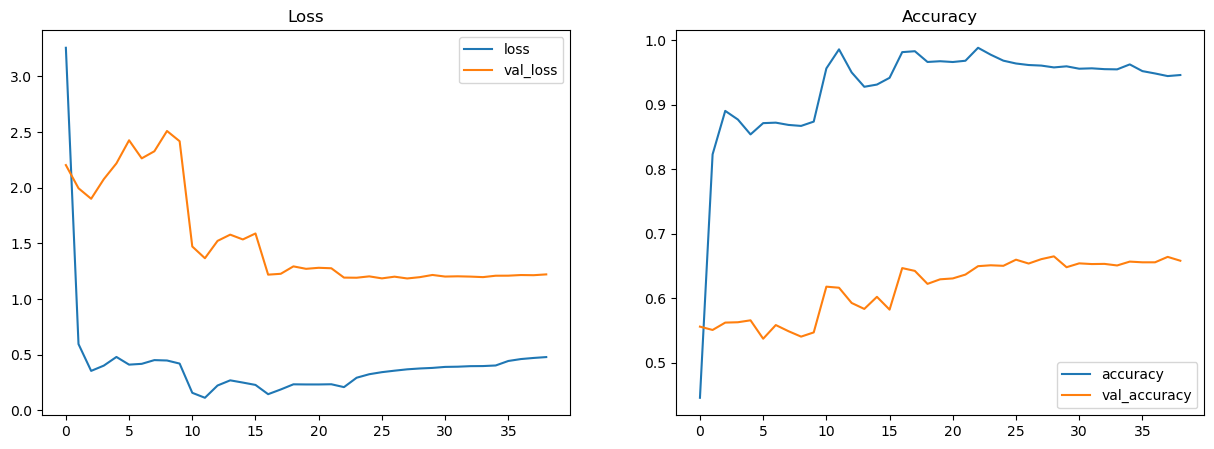

65/65 [==============================] - 15s 236ms/step - loss: 1.1881 - accuracy: 0.6497
Evaluation results: [loss, accuracy] [1.1881334781646729, 0.6496598720550537]


In [16]:
# Evaluate and Save model
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

In [10]:
# Data Augmentation

# https://www.tensorflow.org/api_docs/python/tf/image/adjust_brightness
def adjust_brightness(image, label):
    return tf.image.adjust_brightness(image, 0.01), label

# https://www.tensorflow.org/api_docs/python/tf/image/adjust_contrast
def adjust_contrast(image, label):
    return tf.image.adjust_contrast(image, 1.2), label

# Randomly flip the image horizontally
def flip_horizontal(image, label):
    return tf.image.random_flip_left_right(image), label

# Randomly flip the image vertically
def flip_vertical(image, label):
    return tf.image.random_flip_up_down(image), label

# Randomly rotate the image
def random_rotate(image, label):
    return tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)), label

# Randomly adjust the brightness and contrast of the image
def random_brightness_contrast(image, label):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    return image, label

# Randomly crop and resize the image
def random_crop_resize(image, label, target_size=(128, 128)):
    # Generate random bounding box parameters
    bbox = tf.image.random_crop(image, size=(target_size[0], target_size[1], 3))
    # Resize the cropped image to the target size
    image = tf.image.resize(bbox, size=target_size)
    return image, label

# Randomly apply Gaussian noise to the image
def random_gaussian_noise(image, label, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=stddev, dtype=tf.float32)
    return tf.clip_by_value(image + noise, 0.0, 1.0), label

# Randomly adjust hue, saturation, and contrast
def random_hue_saturation(image, label):
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    return image, label

# Apply data processing + data augmentation steps
# data_process_list=[load_image, normalize, flip_horizontal, flip_vertical, random_rotate, random_hue_saturation, random_brightness_contrast]
data_process_list = [load_image, normalize, adjust_brightness, adjust_contrast]
# Build data generators for train, validate, test
train_data, validation_data, test_data = build_data_generators(train_data_process_list=data_process_list)
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>
validation_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>
test_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>


In [11]:
# ResNet50V2 with Data Augmentation
model_name = "tf210_ResNet50V2_DataAug"
non_augmented_model_name = "tf210_ResNet50V2"
learning_rate = 0.0001

# Model Checkpoint
checkpoint_filepath = './Checkpoints/' + model_name
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# Build the model
model = build_resnet_model(model_name=model_name)

# Loads the weights
checkpoint_path = './Checkpoints/'+non_augmented_model_name
model.load_weights(checkpoint_path)

# Optimier
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])


In [12]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [13]:
# Train ResNet50V2 with Data Augmentation
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback, reduce_lr,l2_callback],
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/100
463/463 [==============================] - ETA: 0s - loss: 0.6119 - accuracy: 0.8630
Epoch 00001: val_accuracy improved from -inf to 0.83451, saving model to ./Checkpoints\tf210_ResNet50V2_DataAug
463/463 [==============================] - 133s 287ms/step - loss: 0.6119 - accuracy: 0.8630 - val_loss: 0.7062 - val_accuracy: 0.8345
Epoch 2/100
463/463 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.9332
Epoch 00002: val_accuracy did not improve from 0.83451
463/463 [==============================] - 100s 215ms/step - loss: 0.4537 - accuracy: 0.9332 - val_loss: 0.8550 - val_accuracy: 0.7815
Epoch 3/100
463/463 [==============================] - ETA: 0s - loss: 0.4322 - accuracy: 0.9436
Epoch 00003: val_accuracy did not improve from 0.83451
463/463 [==============================] - 117s 253ms/step - loss: 0.4322 - accuracy: 0.9436 - val_loss: 0.9488 - val_accuracy: 0.7481
Epoch 4/100
463/463 [==============================] - ETA: 0s - loss: 0.4225 - ac

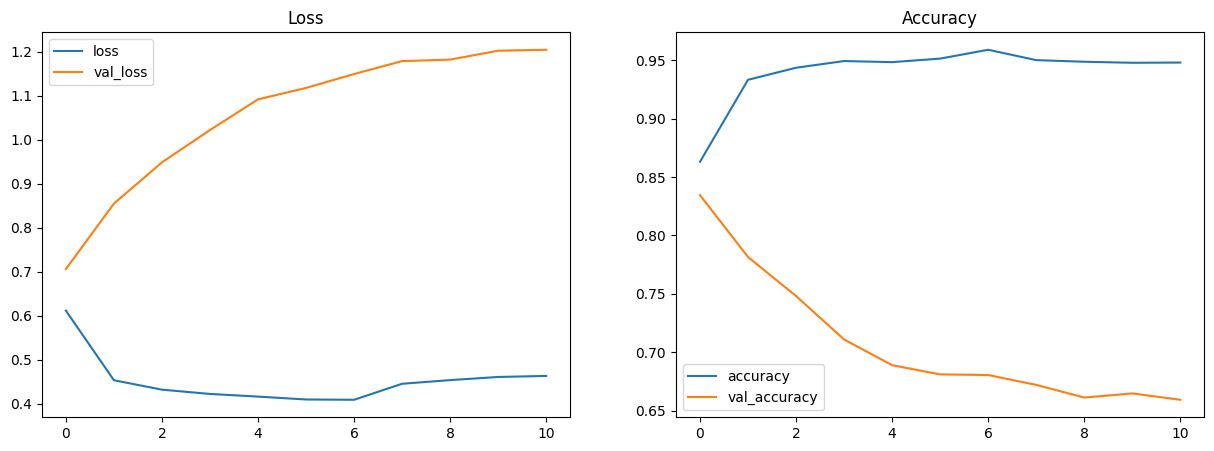

65/65 [==============================] - 2s 33ms/step - loss: 0.6729 - accuracy: 0.8513
Evaluation results: [loss, accuracy] [0.6728987097740173, 0.851311981678009]


In [14]:
# Evaluate and Save model
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

65/65 [==============================] - 2s 25ms/step


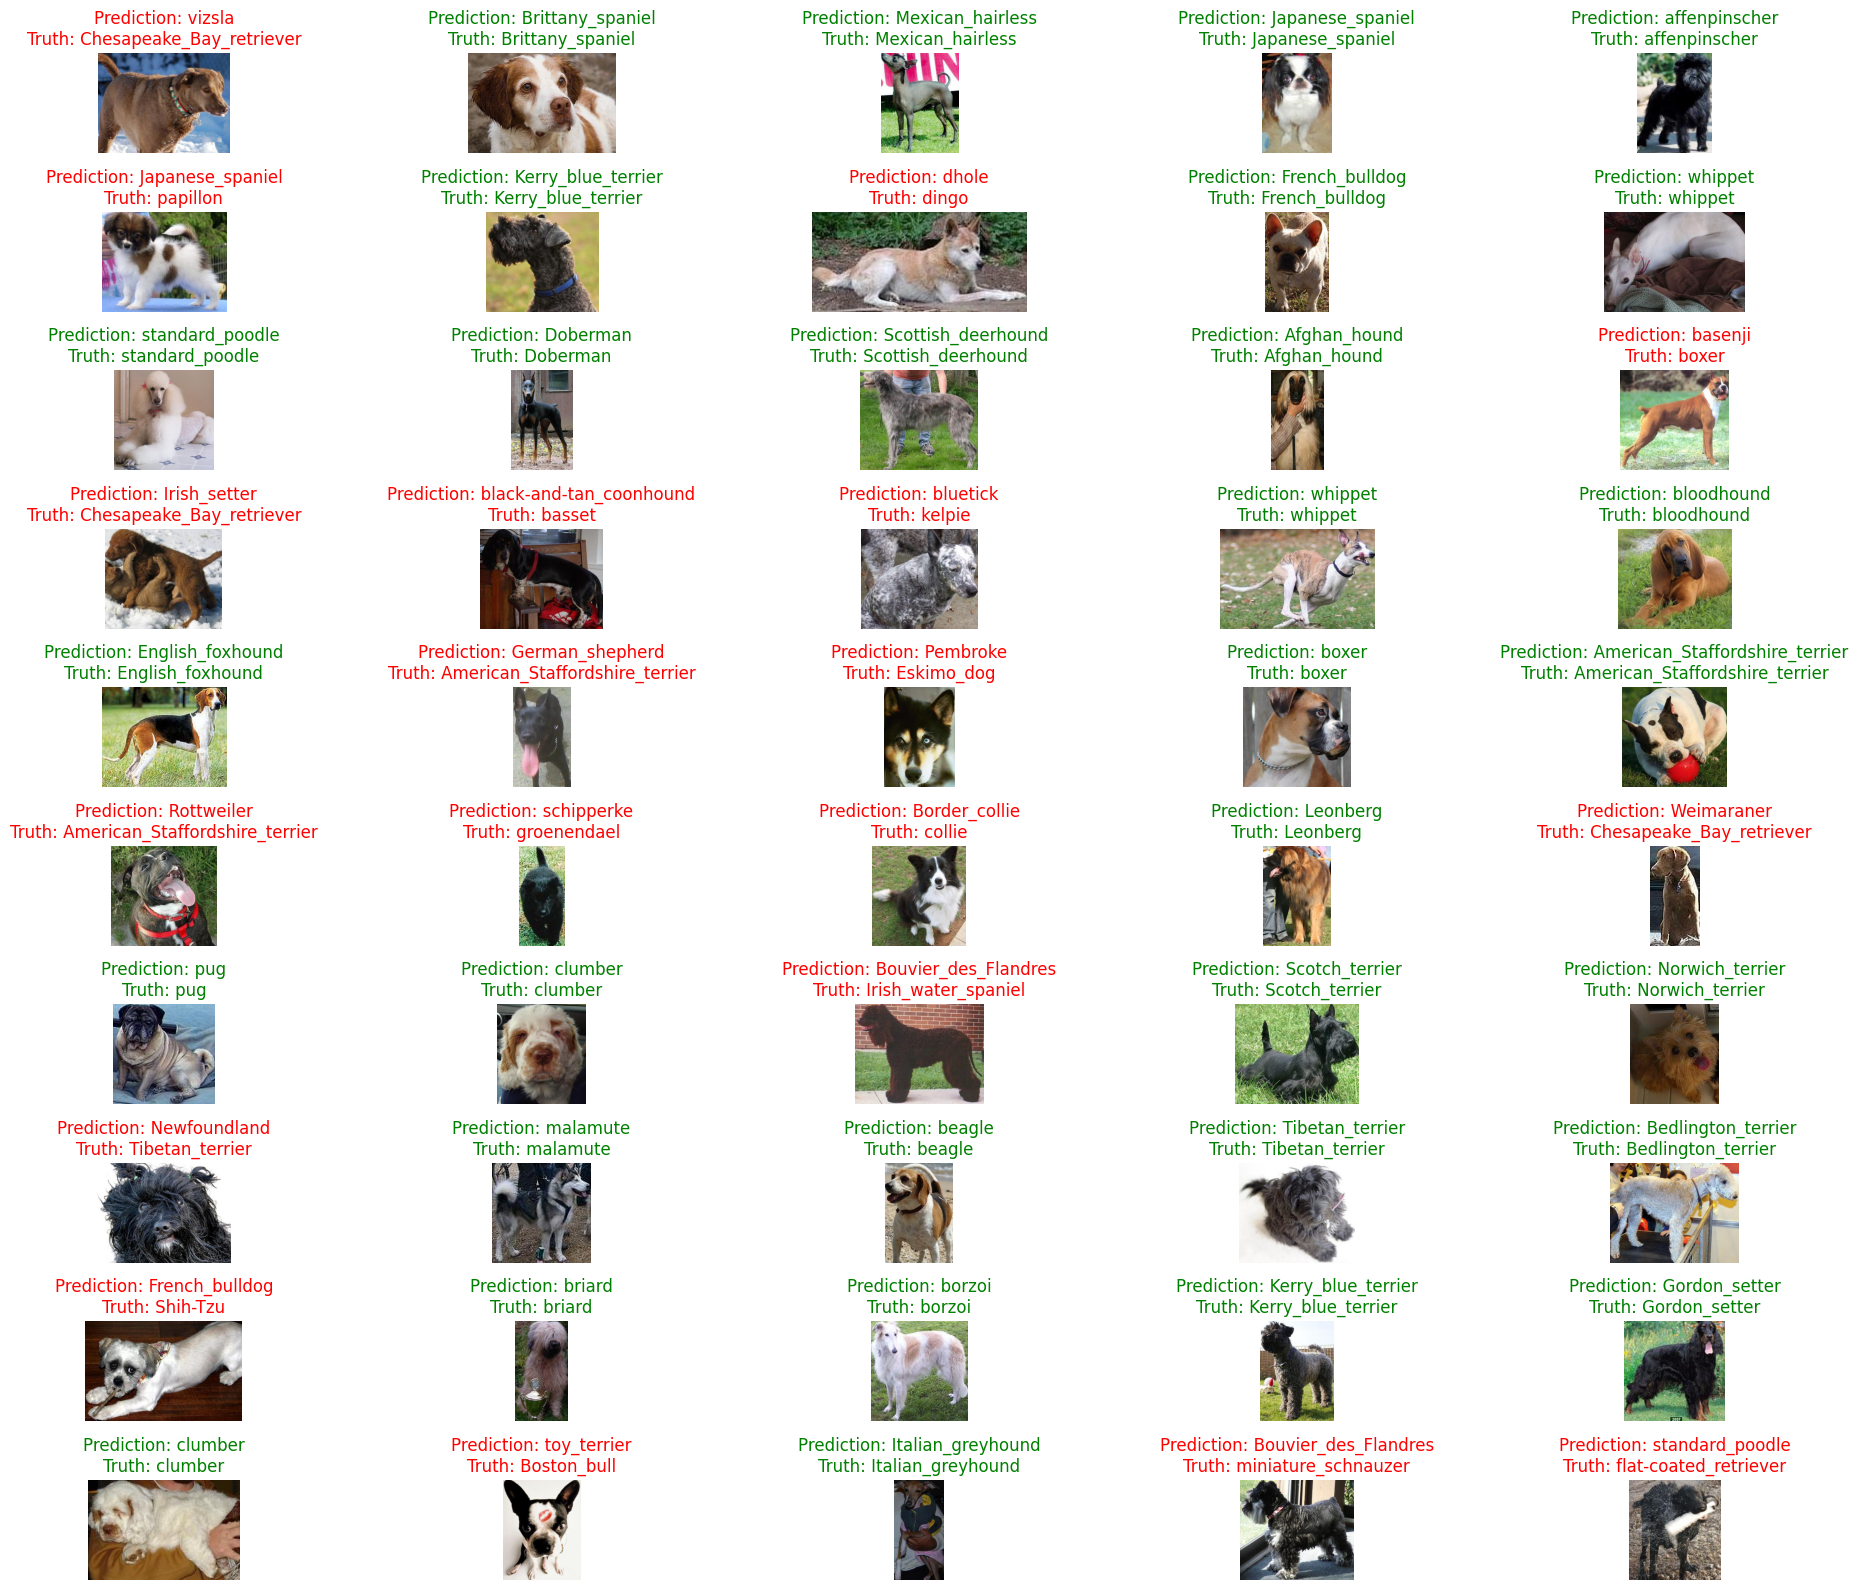

# of true predictions:  31
# of false predictions:  19


In [18]:
# Display predictions
# load best model with best weights
prediction_model = tf.keras.models.load_model('./SavedModels/'+model_name+'.hdf5', compile=False)
prediction_model.compile()
checkpoint_path = './Checkpoints/'+model_name
prediction_model.load_weights(checkpoint_path)

# make predictions
test_predictions = prediction_model.predict(test_data)

# Load Test images
test_x_display = []
for path in test_x:
    path = path.replace("/", "\\")
    # read image
    image = cv2.imread(path)
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Train x
    test_x_display.append(image)
# Convert to numpy array
test_x_display = np.asarray(test_x_display, dtype=object)

# add true and predicted breed for each dog image
# mark it green if prediction is true, otherwise red
# count the total number of true predictions for the first 100 images
true_predict = 0
false_predict = 0
fig = plt.figure(figsize=(20,16))
for i,file in enumerate(test_x_display[:50]):
    axs = fig.add_subplot(10,5,i+1)
    axs.set_aspect('equal')
    predicted_breed = index2label[test_predictions.argmax(axis=1)[i]][10:] # [10:] truncates leading unnecessary letters
    true_breed = test_y[i][10:]
    # color code true/false predictions
    if true_breed == predicted_breed:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='green')
      true_predict += 1
    else:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='red')
      false_predict += 1
    plt.imshow(test_x_display[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

print('# of true predictions: ', true_predict)
print('# of false predictions: ', false_predict)

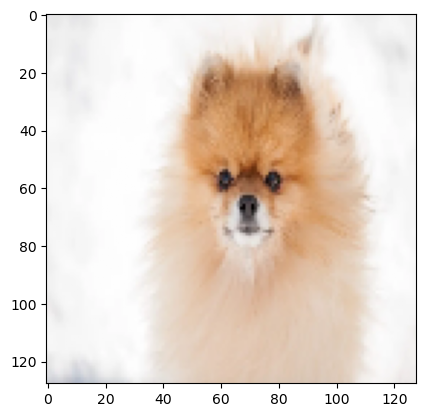

In [38]:
# HERE
# test_img = tf.keras.preprocessing.image.load_img(
#     'C:\\Users\Felix\Downloads\Shih-tzu-dog.jpg', target_size=(128, 128)
# )
test_img = tf.keras.preprocessing   .image.load_img('C:\\Users\Felix\Downloads\pom.jpg', target_size=(128, 128))
test_img = tf.keras.preprocessing.image.img_to_array(test_img)
# test_img = np.expand_dims(test_img, axis=0)
test_img = test_img/255
plt.imshow(test_img)
test_img = np.asarray([test_img])

In [39]:
# predict on test_img
import pickle
# load best model with best weights
prediction_model = tf.keras.models.load_model('./SavedModels/GOOD_ResNet50V2_DataAug.hdf5', compile=False) #path to model XXX_ResNet50V2DataAug.hdf5
prediction_model.compile()
checkpoint_path = './Checkpoints/GOOD_ResNet50V2DataAug' #path to checkpoint XXX_ResNet50V2DataAug
prediction_model.load_weights(checkpoint_path)

# make predictions
test_predictions = prediction_model.predict(test_img)
with open('label2index.pickle', 'rb') as f:
    class_arr = pickle.load(f)
class_arr = {v: k for k, v in class_arr.items()}
print(class_arr[test_predictions.argmax(axis=1)[0]])



n02112018-Pomeranian
